For the purposes of classification, we have so far explored a class of model called the *generative model*, so called because it is possible to generate synthetic based on this model.  Markov models (and HMMs), graphical models, and naive Bayes all fell into this category.  This process was based on the notion that we could specify the joint probability distribution of the class and the feature values:
$$P(\mathbf{x},y),$$
where $\mathbf{x}$ is a vector of features, and $y$ is a class label.

It was then easy to use Bayes' rule to infer the class:
$$
P(y|\mathbf{x}) \propto P(\mathbf{x}|y)P(y).
$$
However, this required the specification of a statistical model for each class (what is the distribution of $\mathbf{x}$ given y).  Consider the lobster example for naive Bayes, in which we assumed that the features $\mathbf{x}$ were normally distributed (independent from one another), with some mean and covariance that depended on which class they were a member of. 
$$
P(\mathbf{x}|y) = \begin{cases} \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_0,\Sigma_0) & \mathrm{if}\;y=0, \\
                                \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_1,\Sigma_1) & \mathrm{if}\;y=1 \end{cases}
$$
where $\boldsymbol{\mu}_1$ and $\Sigma_1$ are the mean and diagonal covariance matrix of the *survived* class (and conversely for $\boldsymbol{\mu}_0$, etc.).  Similarly we had a prior
$$
P(y=1) = \pi_1 = 1-P(y=0) = 1-\pi_0
$$
which is the probability of a lobster's survival without knowing its size.

This was straightforward to code:

Text(0,0.5,'P(survival|lobster size)')

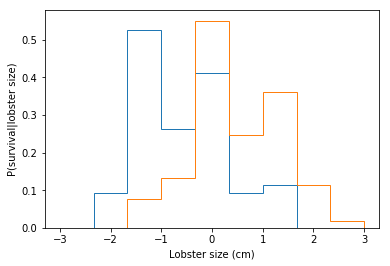

In [2]:
from __future__ import division    # Eliminates annoying default integer division behavior
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('datasets/lobster_survive.dat',header=0,sep=r"\s{2,}",engine='python')
X = data['Len'].values

# z-normalization
X = X - X.mean()
X = X/X.std()

Y = data['Survive'].values

m = len(Y)
N = 2
n = 1

plt.hist(X[y==0],np.linspace(-3,3,10),density=True,histtype='step')
plt.hist(X[y==1],np.linspace(-3,3,10),density=True,histtype='step')
plt.xlabel('Lobster size (cm)')
plt.ylabel('P(survival|lobster size)')

we fit our model by finding maximum likelihood estimates of the joint distribution
$$
P(X,Y|\Theta) = \prod_{i=1}^m P(\mathbf{x}_i|y_i) P(y_i),
$$
where
$$
X = \begin{bmatrix} \mathbf{x}_1 \\
                    \mathbf{x}_2 \\
                    \vdots \\
                    \mathbf{x}_m \end{bmatrix},
$$
and 
$$
Y = \begin{bmatrix} y_1 \\
                    y_2 \\
                    \vdots \\
                    y_m \end{bmatrix}
$$
are the training data and training labels, and $\Theta$ is the vector of parameters ($\Theta = [\mu_0,\mu_1,\Sigma_0,\Sigma_1,\pi_0,\pi_1]$).

The maximum likelihood estimators for which for the means and covariances of each Gaussian turned out to be the sample mean and sample variance of the training data for class:

Text(0,0.5,'P(survival|lobster size)')

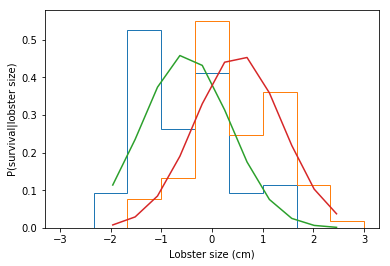

In [3]:
mu_0 = X[Y==0].mean()
mu_1 = X[Y==1].mean()

sigma2_0 = np.cov(X[Y==0])
sigma2_1 = np.cov(X[Y==1])

from scipy.stats import norm
P_X_given_y1 = norm.pdf(X,mu_0,np.sqrt(sigma2_0))
P_X_given_y2 = norm.pdf(X,mu_1,np.sqrt(sigma2_1))

plt.hist(X[Y==0],np.linspace(-3,3,10),density=True,histtype='step')
plt.hist(X[Y==1],np.linspace(-3,3,10),density=True,histtype='step')
plt.plot(X,P_X_given_y1)
plt.plot(X,P_X_given_y2)

plt.xlabel('Lobster size (cm)')
plt.ylabel('P(survival|lobster size)')


The prior probabilities of each class (i.e. $P(y=1)=\pi_1$) can be found by just counting the fraction of the lobsters that survived (or the fraction that died)

In [5]:
pi_0 = sum(Y==0)/m
pi_1 = sum(Y==1)/m

Classification was as easy as asking which class had the higher probability, given the data?

In [ ]:
# What's the probability of survival for a lobster that is half a standard deviation below the mean in size.
X_new = -0.5

posterior_0 = norm.pdf(X_new,mu_0,np.sqrt(sigma2_0))*pi_0
posterior_1 = norm.pdf(X_new,mu_1,np.sqrt(sigma2_1))*pi_1
psum = posterior_0 + posterior_1

posterior_0/=psum
posterior_1/=psum

print("Probability of lobster death is: ",posterior_0)
print("Probability of lobster survival is: ",posterior_1)

This is all well and good, but sometimes it's not so easy to make an assumption about how the data are distributed!  Why should lobster size be normally distributed?  How do we even know?  This leads us to an alternative way to perform classification called *discriminative classification*, in which rather than model the features as an explicit statistical model, we'll come up with a function that takes as input the features, and outputs a probability for each class.  

What function should we use for such an endeavor?  Let's begin by looking at the two-class naive Bayes model again, where we are interested in the survival probability.  By definition, 
$$
P(y=1|\mathbf{x}) = \frac{P(\mathbf{x}|y=1)P(y=1)}{P(\mathbf{x}|y=1)P(y=1) + P(\mathbf{x}|y=0)P(y=0)}.
$$
We can factorize this as follows:
$$
P(y=1|\mathbf{x}) = \frac{1}{1 + \frac{P(\mathbf{x}|y=0)P(y=0)}{P(\mathbf{x}|y=1)P(y=1)}}.
$$
Then making the substitution
$$
a(\mathbf{x}) = \ln \frac{P(\mathbf{x}|y=1)P(y=1)}{P(\mathbf{x}|y=0)P(y=0)},
$$
we have that 
$$
P(y=1|\mathbf{x}) = \frac{1}{1 + \mathrm{e}^{-a}}.
$$
The quantity $a$ is the (logarithm of the) ratio of probabilities, also known as the odds.  Thus $a$ is called the log-odds.  This is a useful quantity because it squishes the odds down to a symmetric function on the complete real line, rather than just a positive value.  

This function on the right hand side ends up being common enough that it has a name: the sigmoid (Greek for s-like)
$$
\sigma(a) = \frac{1}{1 + \mathrm{e}^{-a}}.
$$
The sigmoid function takes a number on the real line, and squashes it down to a value between zero and one, a proper probability.  Here's what it looks like


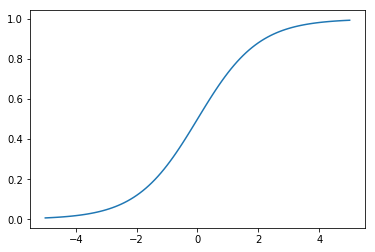

In [7]:
a = np.linspace(-5,5,101)

def sigmoid(a):
    return 1./(1+np.exp(-a))

plt.plot(a,sigmoid(a))
plt.show()

This gives us some insight into what naive Bayes is doing: we're taking the log-odds of the data for the two classes, and turning it into a class probability by running it through the logistic function.  

As it turns out, in this univariate case if we use the naive Bayes model, we can write $a$ as a quadratic function of the features (dropping the bold on $x$, since it's just a scalar):
$$
a(x) = w_2 x^2 + w_1 x + w_0 ,
$$
where 
$$
w_2 = \frac{1}{2}\left[\frac{1}{\sigma^2_0} - \frac{1}{\sigma^2_1}\right]
$$
$$
w_1 = \frac{\mu_1}{\sigma^2_1} - \frac{\mu_0}{\sigma^2_0}
$$
$$
w_0 = -\frac{1}{2}\frac{\mu_1^2}{\sigma_1^2} + \frac{1}{2}\frac{\mu_0^2}{\sigma_0^2} + \ln\frac{\pi_1}{\pi_0}.
$$
It's important to recognize that by using these definitions, we haven't done anything different from normal naive Bayes.  We can show this by computing the probability using the normal naive Bayes thing of evaluating the probability for each class, then normalizing and comparing it to what we get using these formulas


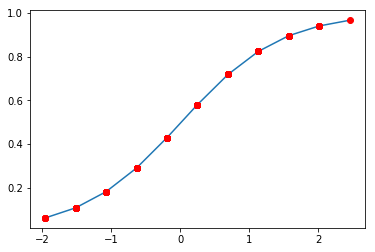

In [8]:
w_2 = 0.5*(1./sigma2_0 - 1./sigma2_1)
w_1 = mu_1/sigma2_1 - mu_0/sigma2_0
w_0 = -0.5*mu_1**2/sigma2_1 + 0.5*mu_0**2/sigma2_0 + np.log(pi_1/pi_0)


w_nb = np.array([w_0,w_1,w_2])

posterior_0 = norm.pdf(X,mu_0,np.sqrt(sigma2_0))*pi_0
posterior_1 = norm.pdf(X,mu_1,np.sqrt(sigma2_1))*pi_1
psum = posterior_0 + posterior_1

posterior_0/=psum
posterior_1/=psum

a = w_0 + w_1*X + w_2*X**2
posterior_logistic = sigmoid(a)

plt.plot(X,posterior_1)
plt.plot(X,posterior_logistic,'ro')
plt.show()


They're the same, we haven't changed anything by writing the classifier in this way.  

The change to logistic regression from naive Bayes comes when we *don't* use these definitions for the parameters defining the log odds $a(x)$.  Instead, what we want to do is find the values of the parameters $\mathbf{w}$ that maximize the accuracy of the model or (equivalently) maximize the probability of a correct classification.  How do we define a function for maximizing the probability of a correct classification?  Well it should be a distribution on the boolean-valued class $y$ given the data $x$.  The Bernoulli distribution is usually appropriate for this sort of thing:
$$
P(y|x) = p(x)^y (1-p(x))^{1-y}.
$$
What should our mean $p(x)$ be?  It should be our prediction:
$$
p(x) = \sigma(w_0 + w_1 x + w_2 x^2).
$$
We can write this more generally as
$$
\theta = \sigma(\mathbf{w}^T \boldsymbol{\phi}(x)),
$$
where $\boldsymbol{\phi}(x) = [1,x,x^2]$, which is basically the expansion of the features as monomials, just like we saw in linear regression.  If we consider all of our data points, we can make a matrix
$$
\Phi(X) = \left[\begin{array}{ccc} 1 & x_1 & x_1^2 \\
                      1 & x_2 & x_2^2 \\
                      \vdots & \vdots & \vdots \\
                      1 & x_m & x_m^2 \end{array}\right]
                     $$
                           
If we assume that all our data points are independent, we can generate a likelihood model that we can maximize:
$$
P(Y|X) = \prod_{i=1}^m P(Y_i|X_i),
$$
where $Y$ is a vector containing all of our class labels.  Substituion of the definition of the Bernoulli in, we get
$$
P(Y|X) = \prod_{i=1}^m \theta(X_i)^{Y_i} (1-\theta(X_i))^{1-Y_i},
$$
where 
$$
\theta(X_i) = \mathbf{w}^T \phi_i.
$$

To find the best values of $\mathbf{w}$, we can maximize this function with respect to it.  Per usual, it can be tricky to find the gradient of this function that has a product in it.  Instead, we'll find the minimum of the negative log-likelihood:
$$
\mathcal{L} = -\sum_{i=1}^m Y_i \ln \theta_i + (1-Y_i) \ln (1-\theta_i).
$$
This log-likelihood shows up fairly frequently, and has it's own name: cross-entropy.  You can think of it as least squares for binary variables, in the sense that it gets big when we mis-classify our data, and it becomes small when we mostly get stuff right.  To minimize it, we'll take the derivative, and try to find the place where it's zero.  The derivative of this function is pretty easy to find, and it turns out to be
$$
\frac{\partial \mathcal{L}}{\partial w_j} = \sum_{i=1}^m [\theta_i - Y_i] \Phi_{ij}.
$$

Unfortunately, unlike in the case of linear regression, we can't simply set these derivatives to zero and solve a linear system of equations to get the values for $w_i$.  Instead, we'll have to search for the optimal parameter values.  How should we do this?  First let's take stock of the information that we have: first, we have a formula for $\theta$,

In [ ]:
Phi = np.vander(X,N=3,increasing=True)

def theta(w,Phi):
    a = np.dot(Phi,w)
    return sigmoid(a)

# The objective function
def L(w,Phi,y):
    likelihood = -sum(y*np.log(theta(w,Phi)) + (1-y)*np.log(1-theta(w,Phi)))
    return likelihood

We also have the derivative of this function with respect to the values of the weights

In [ ]:
# The gradient of the objective function
def dLdw(w,Phi,y):
    return np.dot(theta(w,Phi)-y,Phi)

Is it possible to just follow this gradient downhill until we can't go downhill anymore?  Absolutely!

This technique is called gradient descent, and the formula is as follows:
$$
\mathbf{w}_{t+1} = \mathbf{w}_t - \eta \nabla_{\mathbf{w}} \mathcal{L}.
$$
Note this parameter $\eta$; this is called the learning rate, and we'll need to adjust it to get good performance.  If it is too small, we won't adjust the parameter very fast and it may take a very long time to reach the minimum.  If it's too large we may skip over the optimal solution without ever seeing it.  There are many variants of this algorithm (we'll explore some later in the course), but for now let's just implement the simplest possible version.

In [ ]:
w = np.random.randn(3)*1.0
eta = 5e-3

cross_entropy = [L(w,Phi,y)]

g_initial = np.sqrt(sum(dLdw(w,Phi,y)**2))
rtol=1e-3
converged=False
while converged==False:
    g = dLdw(w,Phi,y)
    w -= eta*g

    gnorm = np.sqrt(sum(g**2))
    if gnorm/g_initial<rtol:
        converged=True
        
    cross_entropy.append(L(w,Phi,y))

plt.plot(cross_entropy)
plt.axhline(L(w_nb,Phi,y),color='red')
plt.show()

Interestingly, the naive Bayes solution is not optimal for this likelihood function (although it's close).  How about the actual training accuracy?

In [ ]:
print(sum((theta(w,Phi)>0.5) == y)/len(y))
print(sum((posterior_1>0.5) == y)/len(y))


Turns out the same.  This isn't too surprising, since there isn't much flexibility in only 1D.  However, next time, we'll develop the capacity to use this model in a multi-class setting, and see how it can substantially out-perform naive Bayes.